<a href="https://colab.research.google.com/github/eschwarzbeckf/forecast_prices/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox as box
from scipy.stats import norm, shapiro

In [ ]:
from sktime.utils.plotting import plot_series, plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import StatsModelsARIMA
from sktime.split import temporal_train_test_split, SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.series.boxcox import LogTransformer

In [ ]:
df = pd.read_csv("consolidated.csv",parse_dates=True,index_col=0)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sales'>)

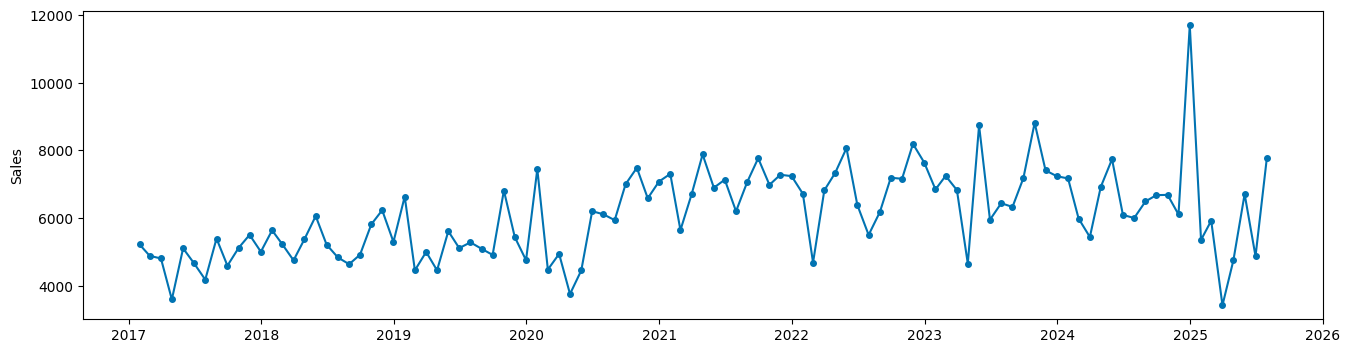

In [ ]:
plot_series(df)

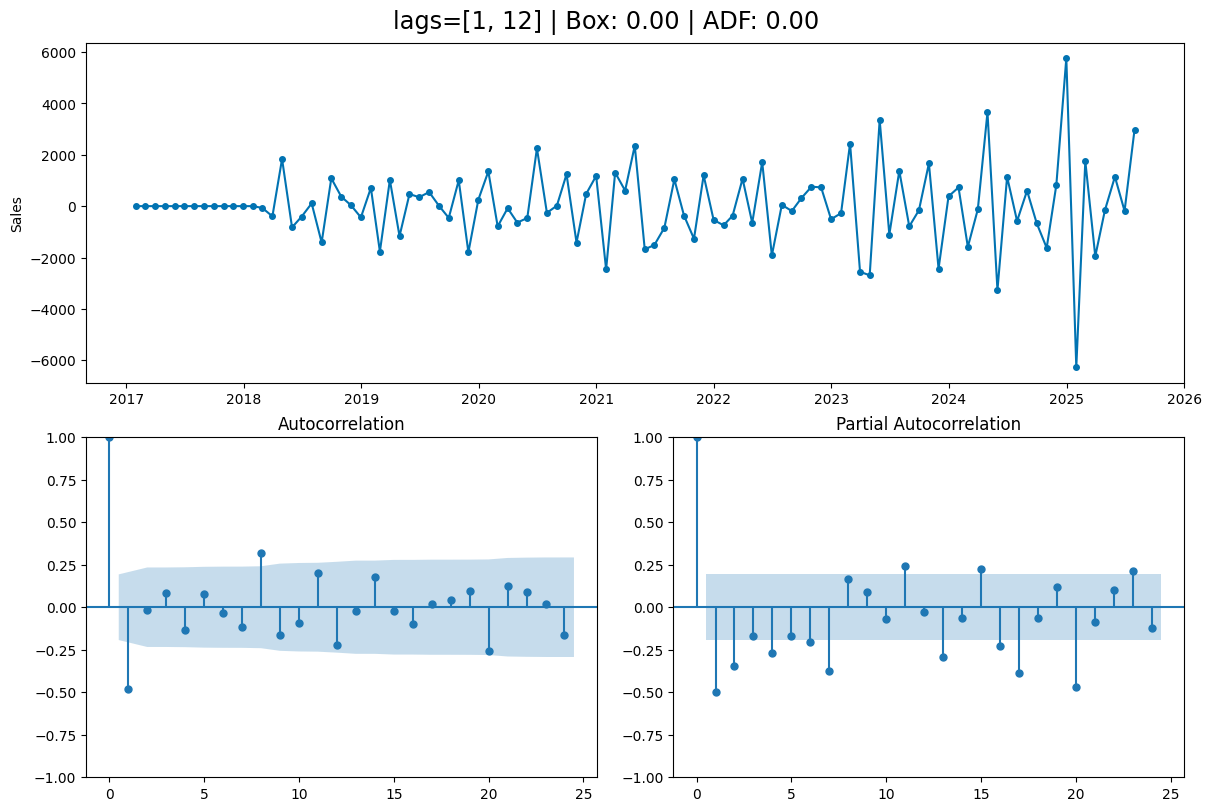

In [ ]:
y = df['Sales']
lags=[1,12]
yy = y if lags == 0 else Differencer(lags=lags).fit_transform(y)
plot_correlations(yy,pacf_method='ols',suptitle=f"lags={lags} | Box: {box(yy,lags=12)['lb_pvalue'].values[-1]:.2f} | ADF: {adfuller(yy,maxlag=12)[1]:.2f}")
plt.show()

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=12)
model = StatsModelsARIMA(order=(0,1,1),seasonal_order=(2,1,0,12),trend='n')
model.fit(y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                   91
Model:             ARIMA(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -641.781
Date:                           Thu, 11 Sep 2025   AIC                           1291.562
Time:                                   18:26:05   BIC                           1300.989
Sample:                               01-31-2017   HQIC                          1295.336
                                    - 07-31-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7741      0.078     -9.871      0.000      -0.928      -0.620
ar.S.L12      -0.3980      0.098     -4.052      0.000      -0.591      -0.205
ar.S.L24      -0.5101      0.100     -5.082      0.000      -0.707      -0.313
sigma2      7.327e+05   1.41e+05      5.213      0.000    4.57e+05    1.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 3.36
Prob(Q):                              0.62   Prob(JB):                         0.19
Heteroskedasticity (H):               2.20   Skew:                             0.50
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


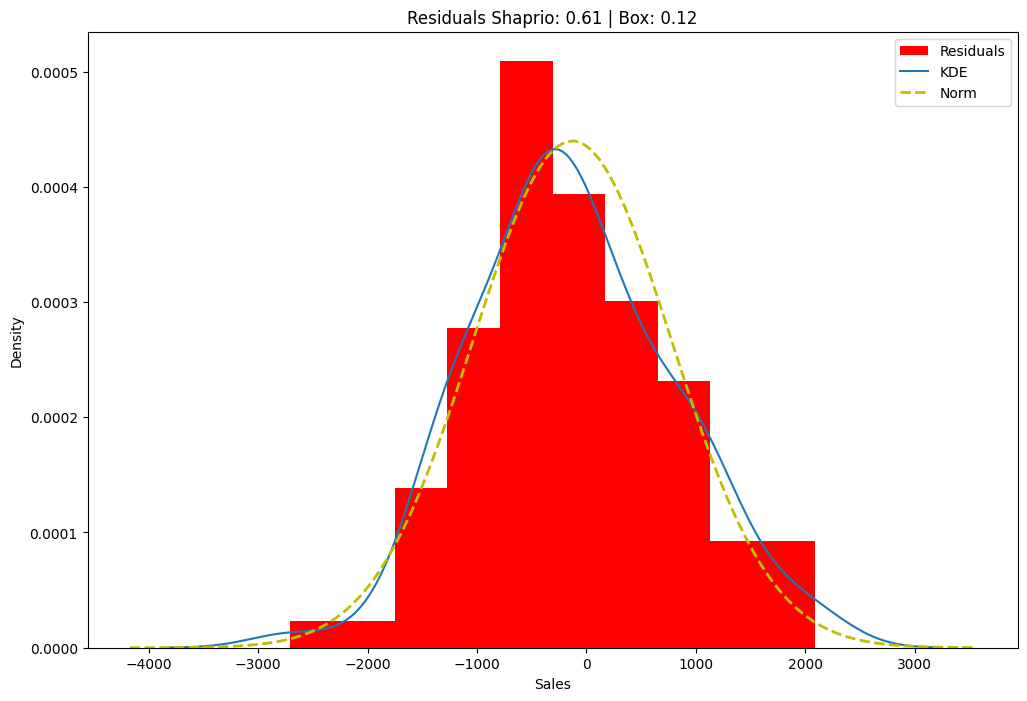

In [ ]:
res = y_train - model.predict(fh=-np.arange(len(y_train)))
res = res.iloc[1:]
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Sales'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

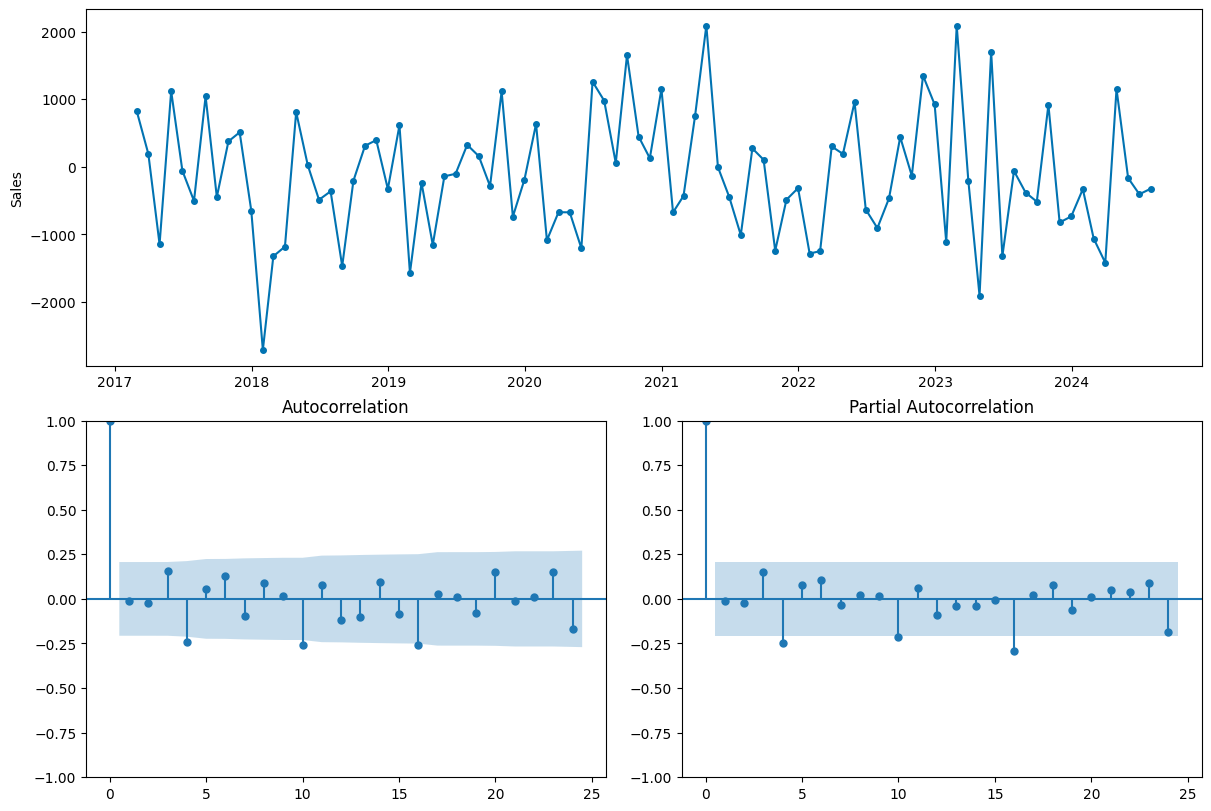

In [ ]:
plot_correlations(res,pacf_method='ols')

In [ ]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


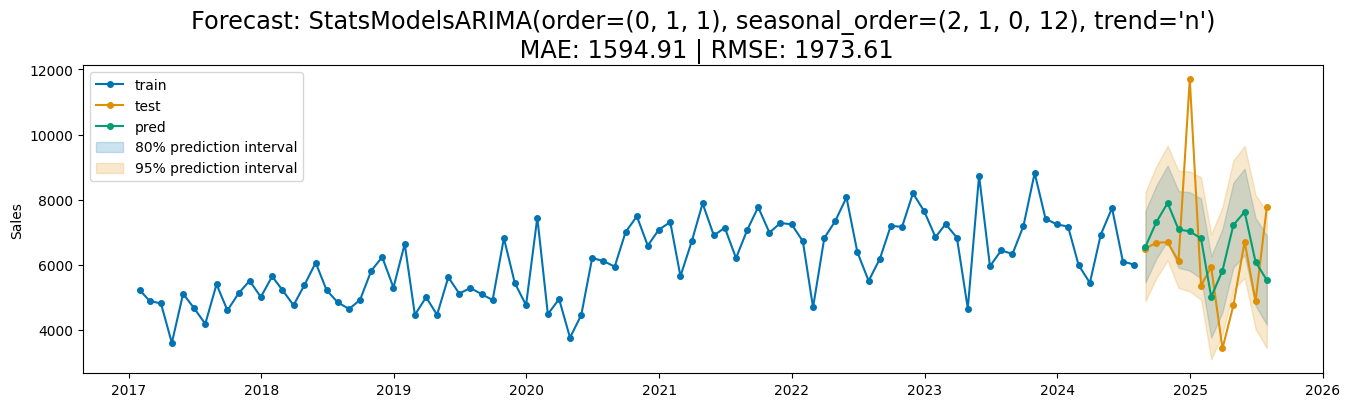

In [ ]:
y_pred = model.predict(fh=y_test.index)
y_ci = model.predict_interval(fh=y_test.index, coverage=[.8,.95])
plot_series(y_train,y_test,y_pred,labels=['train','test','pred'],title=f'Forecast: {model}\n MAE: {mae.evaluate(y_test,y_pred):.2f} | RMSE: {rmse.evaluate(y_test,y_pred):.2f}',pred_interval=y_ci)
plt.show()

In [ ]:
cv=ExpandingWindowSplitter(fh=np.arange(1,4),step_length=3,initial_window=len(df)-3*10)
results = evaluate(model,cv=cv,y=df,scoring=[mae,rmse],return_data=True)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a f

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


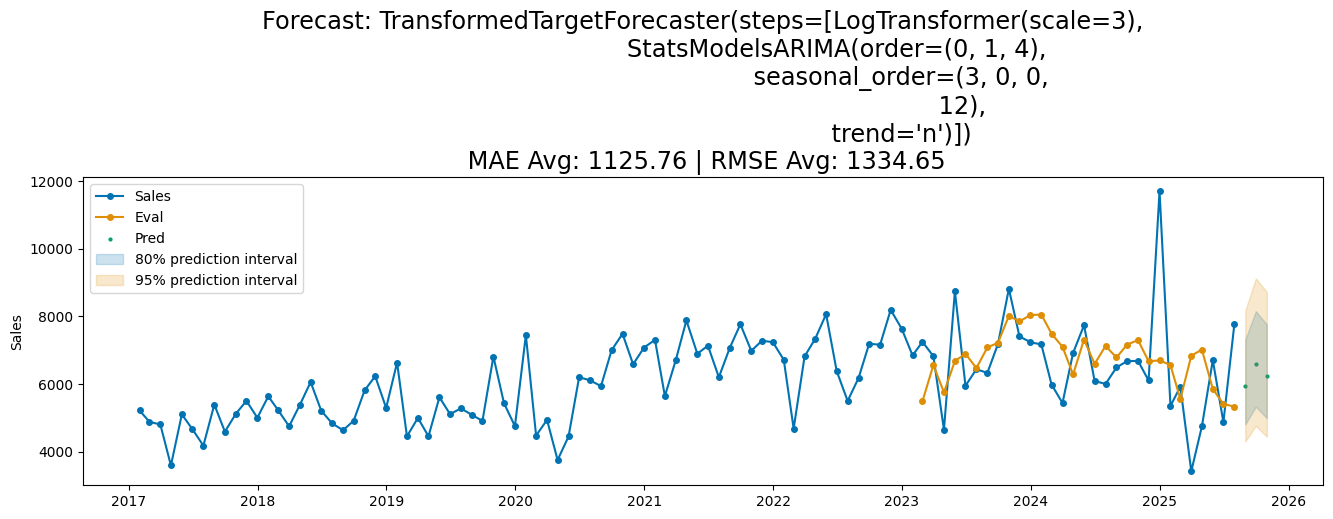

In [ ]:
b = ['Sales']
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
b.append('Eval')
model.fit(df)
y_pred = model.predict(fh=pd.date_range(start='2025-08',periods=3,freq='ME'))
b.append('Pred')
y_ci = model.predict_interval(fh=pd.date_range(start='2025-08',periods=3,freq='ME'),coverage=[0.8,0.95])

plot_series(df,test,y_pred,labels=b,title=f'Forecast: {model}\n MAE Avg: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE Avg: {results['test_MeanSquaredError'].mean():.2f}',pred_interval=y_ci)
plt.show()

In [ ]:
df = pd.read_csv('consolidated.csv',parse_dates=True,index_col=0)

In [ ]:
df.shift([0,1,2,3,12,20]).corr().where(lambda x: np.abs(x) > 0.3).loc[:,:"Tasa de interés promedio de créditos en pesos a tasa fija_0"]

,Sales_0,CAT mínimo de créditos en pesos a tasa fija_0,CAT máximo de créditos en pesos a tasa fija_0,CAT promedio de créditos en pesos a tasa fija_0,Tasa de interés asociada al CAT mínimo de créditos en pesos a tasa fija_0,Tasa de interés asociada al CAT máximo de créditos en pesos a tasa fija_0,Tasa de interés promedio de créditos en pesos a tasa fija_0
Sales_0,1.000000,-0.355362,0.333150,NaN,NaN,0.327770,NaN
CAT mínimo de créditos en pesos a tasa fija_0,-0.355362,1.000000,0.337872,0.727721,0.877188,0.345480,0.637758
CAT máximo de créditos en pesos a tasa fija_0,0.333150,0.337872,1.000000,0.837303,0.449841,0.991725,0.883629
CAT promedio de créditos en pesos a tasa fija_0,NaN,0.727721,0.837303,1.000000,0.725359,0.829756,0.967605
Tasa de interés asociada al CAT mínimo de créditos en pesos a tasa fija_0,NaN,0.877188,0.449841,0.725359,1.000000,0.470051,0.631158
Tasa de interés asociada al CAT máximo de créditos en pesos a tasa fija_0,0.327770,0.345480,0.991725,0.829756,0.470051,1.000000,0.878446
Tasa de interés promedio de créditos en pesos a tasa fija_0,NaN,0.637758,0.883629,0.967605,0.631158,0.878446,1.000000
Sales_1,0.364753,-0.325877,0.327150,NaN,NaN,0.329623,NaN
CAT mínimo de créditos en pesos a tasa fija_1,-0.351526,0.974782,0.326059,0.712580,0.850121,0.333490,0.607744
CAT máximo de créditos en pesos a tasa fija_1,0.317269,0.354386,0.994505,0.835839,0.454825,0.984663,0.882027


In [ ]:
for p in [0,1,2,3,12,24]:
  df[f'Lag_{p}'] = df['Sales'].diff(p)

In [ ]:
df.columns

Index(['Sales', 'CAT mínimo de créditos en pesos a tasa fija',
       'CAT máximo de créditos en pesos a tasa fija',
       'CAT promedio de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT mínimo de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT máximo de créditos en pesos a tasa fija',
       'Tasa de interés promedio de créditos en pesos a tasa fija'],
      dtype='object')

,CAT mínimo de créditos en pesos a tasa fija_0,CAT mínimo de créditos en pesos a tasa fija_1,CAT mínimo de créditos en pesos a tasa fija_2,CAT mínimo de créditos en pesos a tasa fija_12
2017-01-31,11.3,0.0,0.0,0.0
2017-02-28,11.3,11.3,0.0,0.0
2017-03-31,11.3,11.3,11.3,0.0
2017-04-30,11.3,11.3,11.3,0.0
2017-05-31,11.3,11.3,11.3,0.0
...,...,...,...,...
2025-03-31,11.2,11.2,11.2,11.2
2025-04-30,11.2,11.2,11.2,11.2
2025-05-31,11.2,11.2,11.2,11.2
2025-06-30,11.2,11.2,11.2,11.2


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             ARIMA(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                  30.455
Date:                            Thu, 11 Sep 2025   AIC                            -52.910
Time:                                    19:40:18   BIC                            -43.535
Sample:                                01-31-2017   HQIC                           -49.160
                                     - 07-31-2024                                         
Covariance Type:                              opg                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
CAT mínimo de créditos en pesos a tasa fija_Lag_0    -0.1326      0.099     -1.339      0.181      -0.327       0.061
ar.L1                                                -0.4086      0.104     -3.923      0.000      -0.613      -0.204
ma.S.L12                                              0.4353      0.112      3.900      0.000       0.217       0.654
sigma2                                                0.0257      0.004      6.799      0.000       0.018       0.033
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.26   Prob(JB):                         0.31
Heteroskedasticity (H):               1.37   Skew:                             0.38
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y = df['Sales']
x = df[['CAT promedio de créditos en pesos a tasa fija']]
x = x.shift(periods=[0,1],fill_value=0,suffix='_Lag')
y_train, y_test, x_train, x_test = temporal_train_test_split(y=y,X=x, test_size=12)
model = LogTransformer() * StatsModelsARIMA(order=(0,1,1),seasonal_order=(0,0,1,12),enforce_stationarity=False,trend='n')
model.fit(y_train,x_train)
try:
  model.summary()
except Exception as e:
  print(e)
  model.forecaster_.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


'TransformedTargetForecaster' object has no attribute 'summary'


In [ ]:
model.forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   91
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                  36.083
Date:                          Thu, 11 Sep 2025   AIC                            -62.165
Time:                                  19:51:23   BIC                            -50.512
Sample:                              01-31-2017   HQIC                           -57.508
                                   - 07-31-2024                                         
Covariance Type:                            opg                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
CAT promedio de créditos en pesos a tasa fija_Lag_0     0.0063      0.193      0.033      0.974      -0.371       0.384
CAT promedio de créditos en pesos a tasa fija_Lag_1     0.0433      0.174      0.249      0.803      -0.297       0.384
ma.L1                                                  -0.7874      0.075    -10.457      0.000      -0.935      -0.640
ma.S.L12                                                0.4266      0.125      3.425      0.001       0.182       0.671
sigma2                                                  0.0219      0.004      5.694      0.000       0.014       0.029
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.54   Prob(JB):                         0.68
Heteroskedasticity (H):               1.34   Skew:                            -0.24
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


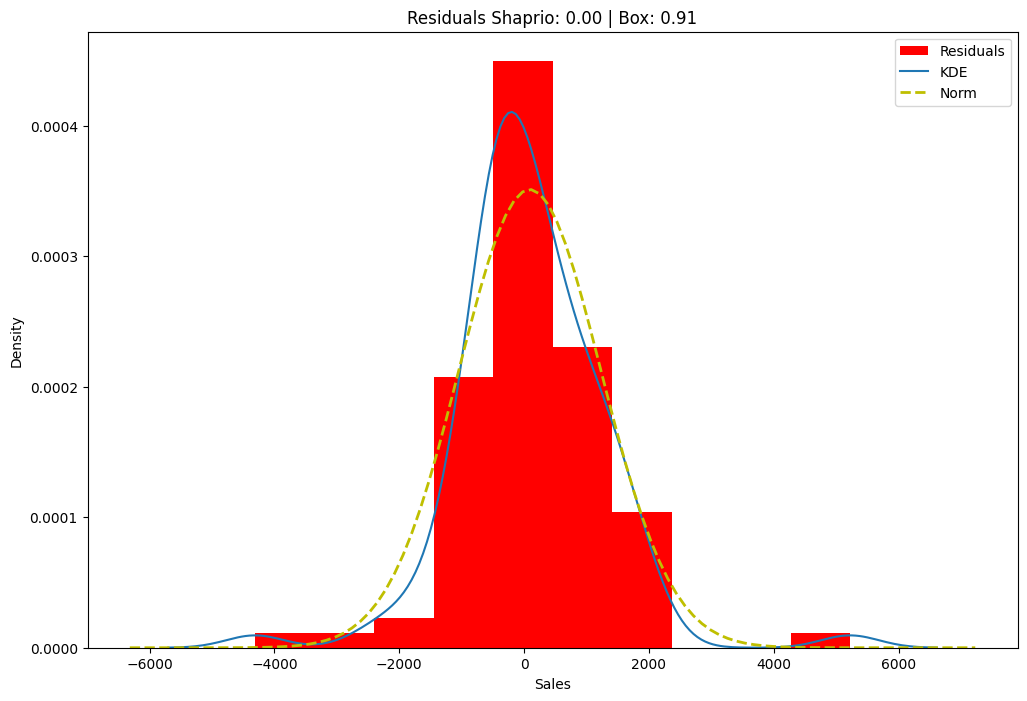

In [ ]:
res = y_train - model.predict(X=x_test,fh=-np.arange(len(y_train)))
# res = res.iloc[1:]
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
resx = np.linspace(xmin, xmax, 100)
p = norm.pdf(resx, mu, std)
ax.plot(resx, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Sales'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

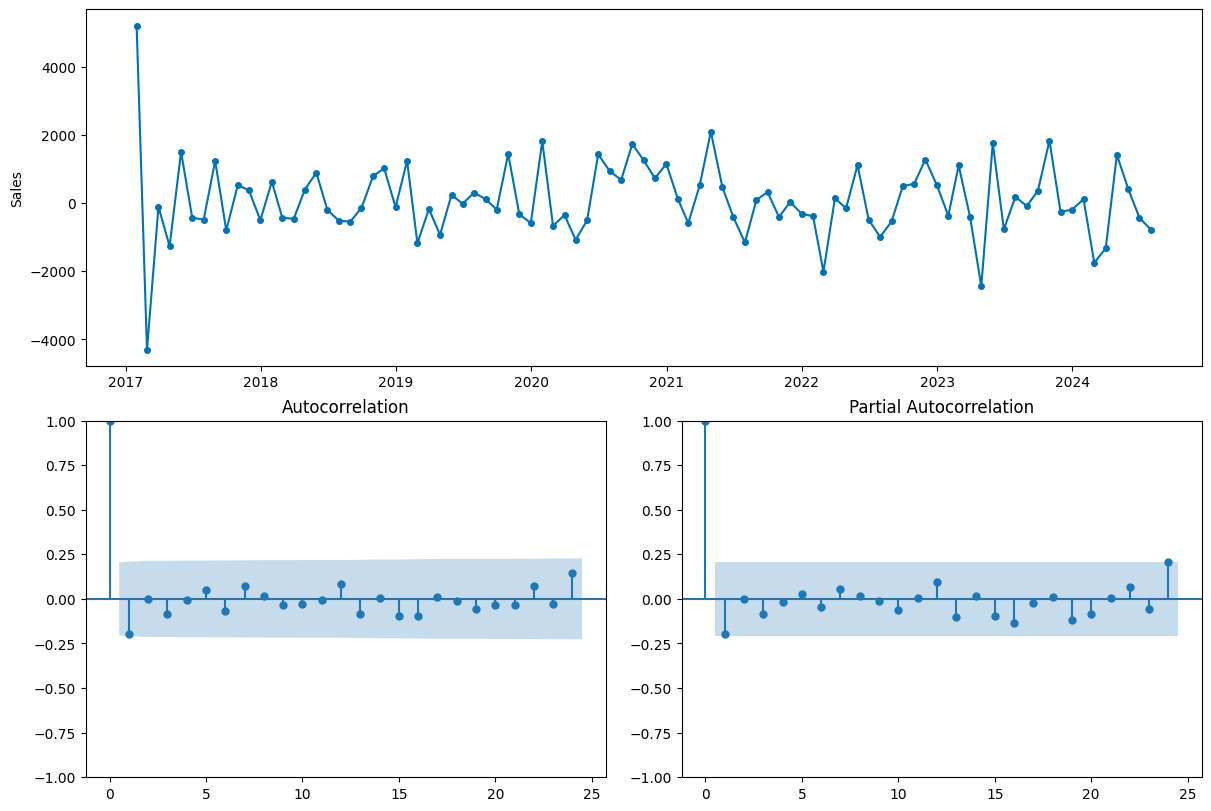

In [ ]:
plot_correlations(res,pacf_method='ols')

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


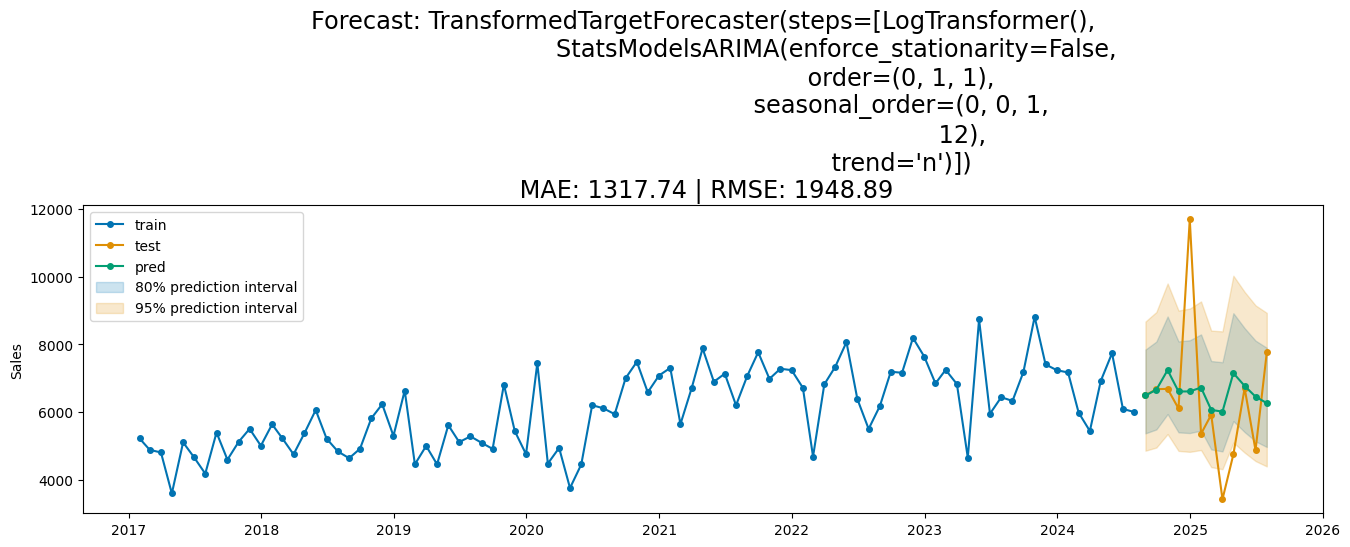

In [ ]:
y_pred = model.predict(X=x_test,fh=y_test.index)
y_ci = model.predict_interval(X=x_test,fh=y_test.index, coverage=[.8,.95])
plot_series(y_train,y_test,y_pred,labels=['train','test','pred'],title=f'Forecast: {model}\n MAE: {mae.evaluate(y_test,y_pred):.2f} | RMSE: {rmse.evaluate(y_test,y_pred):.2f}',pred_interval=y_ci)
plt.show()

In [ ]:
cv=ExpandingWindowSplitter(fh=np.arange(1,4),step_length=3,initial_window=len(df)-3*10)
results = evaluate(model,cv=cv,y=y,X=x,scoring=[mae,rmse],return_data=True)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolut

/tmp/ipython-input-3079890353.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  test = pd.concat([test,d])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/states

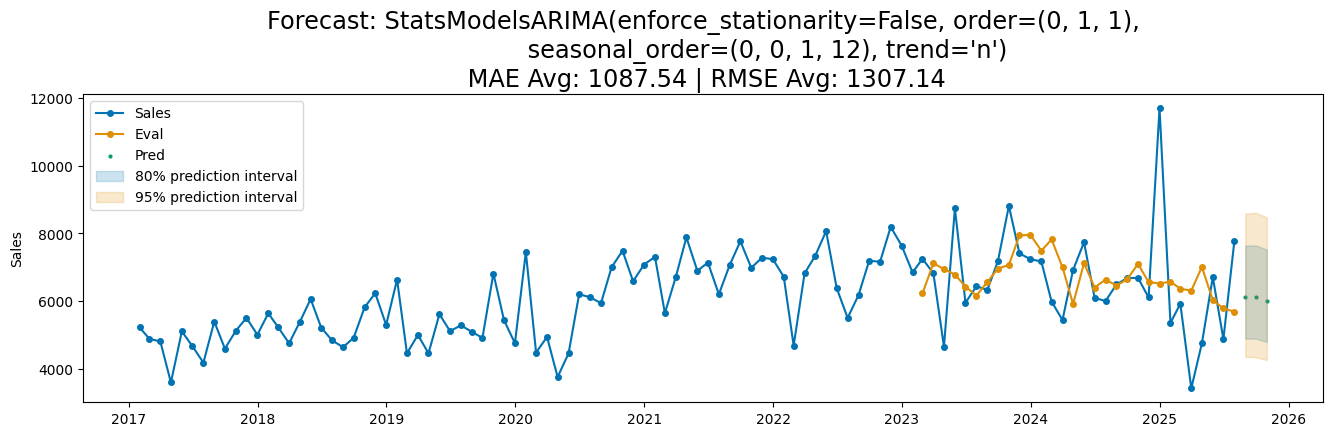

In [ ]:
b = ['Sales']
fh = pd.date_range('2025-08',periods=3,freq='ME')
x_pred = pd.DataFrame([11.2,11.2,11.2],index=fh,columns=['CAT mínimo de créditos en pesos a tasa fija']).shift(periods=[0],fill_value=0,suffix='_Lags')
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
b.append('Eval')
model.fit(y,x)
y_pred = model.predict(X=x_pred,fh=fh)
y_pred = pd.DataFrame(y_pred,index=fh,columns=['Sales'])
b.append('Pred')
y_ci = model.predict_interval(X=x_pred,fh=fh,coverage=[0.8,0.95])

plot_series(y,test,y_pred,labels=b,title=f'Forecast: {model.forecaster_}\n MAE Avg: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE Avg: {results['test_MeanSquaredError'].mean():.2f}',pred_interval=y_ci)
plt.show()